## MNIST

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
sys.path.append("..")

%matplotlib inline

import numpy as np

from sklearn.metrics import classification_report

import keras
from keras import metrics
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model, load_model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output

from art.config import ART_DATA_PATH
from art.estimators.classification import KerasClassifier
from art.utils import to_categorical, load_dataset, get_file

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from deepfool import DeepFool

## MNIST

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

path = get_file('mnist_cnn_original.h5', extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/p2nyzne9chcerid/mnist_cnn_original.h5?dl=1')

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=True)
classifier_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
history = classifier.fit(x_train, y_train, nb_epochs=1, batch_size=128, verbose=1)

468/468 [==============================] - 4s 8ms/step - batch: 233.5000 - size: 128.0000 - loss: 6.1557e-04 - tp: 59899.0000 - fp: 5.0000 - tn: 539131.0000 - fn: 5.0000 - categorical_accuracy: 0.9999 - precision: 0.9999 - recall: 0.9999 - auc: 1.0000


In [4]:
classifier_model.summary()
pred = classifier.predict(x_test)
x_test_pred = np.argmax(pred, axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))
accuracy = np.mean(np.argmax(pred, axis=1) == np.argmax(y_test, axis=1))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [5]:
print(f"---Original test images---:")
print("Correctly classified: {}".format(nb_correct_pred))
print("Accuracy on test samples: %f" % accuracy)

---Original test images---:
Correctly classified: 9918
Accuracy on test samples: 0.991800


In [7]:
num = 100
attacker = DeepFool(classifier)
x_test_adv = attacker.generate(x_test[:num])

Targeted model should output logits, not probabilities for predictions.
DeepFool: 100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


In [8]:
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test[:num], axis=1)) / y_test.shape[0]
print(acc*100)

0.9199999999999999


Original test data (first 100 images):
Correctly classified: 92
Incorrectly classified: 8


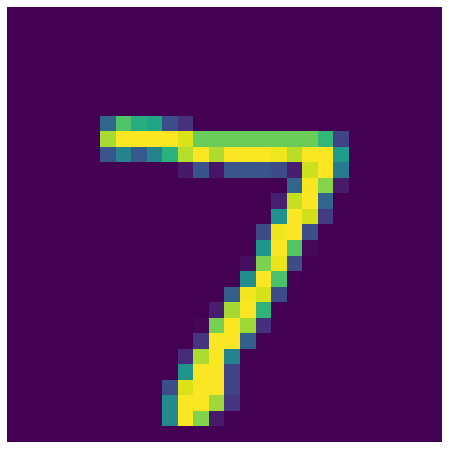

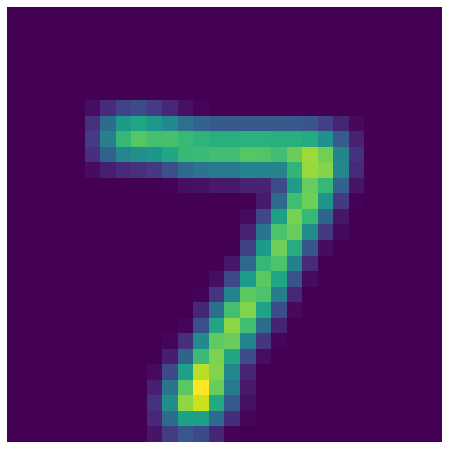

Adversarial test data (first 100 images):
Correctly classified: 94
Incorrectly classified: 6
Classified as targeted label: 15




In [17]:
x_test_pred = np.argmax(classifier.predict(x_test_adv[:num]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:num], axis=1))
print(f"Original test data (first {num} images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(num-nb_correct_pred))

from defence.SSmoothing import SpatialS
img = []

plt.figure(figsize=(8,8)); plt.imshow(x_test_adv[0]); plt.axis('off'); plt.show()

for i in range(len(x_test_adv)):
    x_dev_def = SpatialS(np.moveaxis(x_test_adv[i], 2, 0), window_size=3, way="mean")
    img.append(np.moveaxis(x_dev_def, 0, 2))
    
x_dev_def = np.array(img)

plt.figure(figsize=(8,8)); plt.imshow(x_dev_def[0]); plt.axis('off'); plt.show()

x_test_adv_pred = np.argmax(classifier.predict(x_dev_def), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:num], axis=1))
print(f"Adversarial test data (first {num} images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num-nb_correct_adv_pred))
nb_preb_as_tar = np.count_nonzero(x_test_adv_pred == np.argmax(y_test[:num], axis=1)[0])
print(f"Classified as targeted label: {nb_preb_as_tar}\n\n")

In [18]:
import defence.detector as detector
x_train_adv = attacker.generate(x_train[:100]) 
dmodel = detector.build_detector(classifier_model)
detector.train(dmodel, x_train[:100], x_train_adv)
detector.result(dmodel, x_test, x_test_adv)

Targeted model should output logits, not probabilities for predictions.
DeepFool: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Train on 200 samples
Epoch 1/20
200/200 [==============================] - 0s 5us/sample - loss: 7.3619 - accuracy: 0.4950
Epoch 2/20
200/200 [==============================] - 0s 5us/sample - loss: 7.4908 - accuracy: 0.4925
Epoch 3/20
200/200 [==============================] - 0s 5us/sample - loss: 7.4952 - accuracy: 0.5000
Epoch 4/20
200/200 [==============================] - 0s 5us/sample - loss: 7.5569 - accuracy: 0.5025
Epoch 5/20
200/200 [==============================] - 0s 5us/sample - loss: 7.4537 - accuracy: 0.5025
Epoch 6/20
200/200 [==============================] - 0s 0s/sample - loss: 7.4767 - accuracy: 0.5050
Epoch 7/20
200/200 [==============================] - 0s 5us/sample - loss: 7.4805 - accuracy: 0.5050
Epoch 8/20
200/200 [==============================] - 0s 5us/sample - loss: 7.5120 - accuracy: 0.5050
Epoch 9/20
200/200 [==============================] - 0s 5us/sample - loss: 7.5105 - accuracy: 0.5050
Epoch 10/20
200/200 [==============================] - 0s 5us/

0

## CFAIR-10

In [19]:
import logging

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout

In [20]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

In [21]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10"))
x_train, y_train = x_train[:5000], y_train[:5000]
x_test, y_test = x_test[:500], y_test[:500]

In [22]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=x_train.shape[1:]))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=METRICS)

In [23]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128, verbose=1)

[INFO] Inferred 17 hidden layers on Keras classifier.


Epoch 1/10
39/39 [==============================] - 1s 24ms/step - batch: 19.0000 - size: 128.0000 - loss: 2.1693 - tp: 41.0000 - fp: 47.0000 - tn: 44881.0000 - fn: 4951.0000 - categorical_accuracy: 0.1831 - precision: 0.4659 - recall: 0.0082 - auc: 0.6510- ETA: 0s - batch: 16.0000 - size: 128.0000 - loss: 2.1923 - tp: 29.0000 - fp: 41.0000 - tn: 37975.0000 - fn: 4195.0000 - categorical_accuracy: 0.1742 - precision: 0.4143 - recall: 0.0069 - auc: 
Epoch 2/10
39/39 [==============================] - 1s 24ms/step - batch: 19.0000 - size: 128.0000 - loss: 1.8778 - tp: 203.0000 - fp: 192.0000 - tn: 44736.0000 - fn: 4789.0000 - categorical_accuracy: 0.3101 - precision: 0.5139 - recall: 0.0407 - auc: 0.7826
Epoch 3/10
39/39 [==============================] - 1s 24ms/step - batch: 19.0000 - size: 128.0000 - loss: 1.6996 - tp: 509.0000 - fp: 384.0000 - tn: 44544.0000 - fn: 4483.0000 - categorical_accuracy: 0.3744 - precision: 0.5700 - recall: 0.1020 - auc: 0.8286
Epoch 4/10
39/39 [============

In [24]:
logger.info("Create DeepFool attack")
adv_crafter = DeepFool(classifier)
#logger.info("Craft attack on training examples")
#x_train_adv = adv_crafter.generate(x_train)
logger.info("Craft attack test examples")
x_test_adv = adv_crafter.generate(x_test)

[INFO] Create DeepFool attack
[INFO] Craft attack test examples
[WARNING] Targeted model should output logits, not probabilities for predictions.
DeepFool: 100%|██████████| 500/500 [01:32<00:00,  5.38it/s]
[INFO] DeepFool attack success rate: 87.20%


In [25]:
preds = np.argmax(classifier.predict(x_test_adv), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
logger.info("Classifier before adversarial training")
logger.info("Accuracy on adversarial samples: %.2f%%", (acc * 100))
classifier.model.evaluate(x_test_adv, y_test, verbose=1)

[INFO] Classifier before adversarial training
[INFO] Accuracy on adversarial samples: 22.80%


[1.650936632156372,
 6.0,
 66.0,
 4434.0,
 494.0,
 0.228,
 0.083333336,
 0.012,
 0.84594625]

Original test data (first 500 images):
Correctly classified: 114
Incorrectly classified: 386


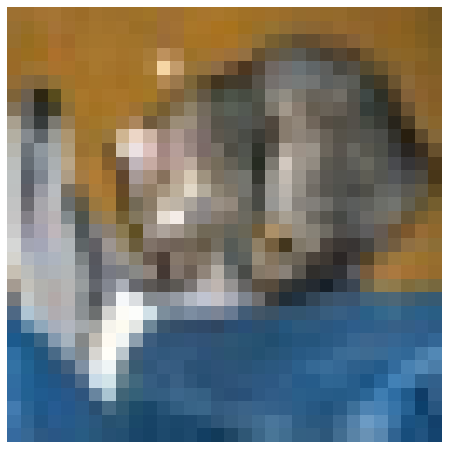

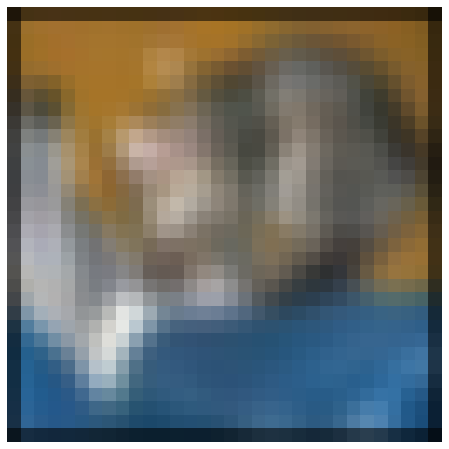

Adversarial test data (first 500 images):
Correctly classified: 167
Incorrectly classified: 333


In [30]:
num = 500
x_test_pred = np.argmax(classifier.predict(x_test_adv[:num]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:num], axis=1))
print(f"Original test data (first {num} images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(num-nb_correct_pred))

from defence.SSmoothing import SpatialS
img = []

plt.figure(figsize=(8,8)); plt.imshow(x_test_adv[0]); plt.axis('off'); plt.show()

for i in range(len(x_test_adv)):
    x_dev_def = SpatialS(np.moveaxis(x_test_adv[i], 2, 0), window_size=3, way="0.5mean")
    img.append(np.moveaxis(x_dev_def, 0, 2))
    
x_dev_def = np.array(img)

plt.figure(figsize=(8,8)); plt.imshow(x_dev_def[0]); plt.axis('off'); plt.show()

x_test_adv_pred = np.argmax(classifier.predict(x_dev_def), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:num], axis=1))
print(f"Adversarial test data (first {num} images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num-nb_correct_adv_pred))

In [33]:
import defence.detector as detector
x_train_adv = adv_crafter.generate(x_train[:500]) 
dmodel = detector.build_detector(model)
detector.train(dmodel, x_train[:500], x_train_adv)
detector.result(dmodel, x_test, x_test_adv)

[WARNING] Targeted model should output logits, not probabilities for predictions.
DeepFool: 100%|██████████| 500/500 [00:22<00:00, 22.07it/s]
[INFO] DeepFool attack success rate: 91.20%


Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 0s 162us/sample - loss: 7.7223 - accuracy: 0.4975
Epoch 2/20
1000/1000 [==============================] - 0s 157us/sample - loss: 7.6895 - accuracy: 0.5000
Epoch 3/20
1000/1000 [==============================] - 0s 153us/sample - loss: 7.6895 - accuracy: 0.5000
Epoch 4/20
1000/1000 [==============================] - 0s 152us/sample - loss: 7.6818 - accuracy: 0.5005
Epoch 5/20
1000/1000 [==============================] - 0s 152us/sample - loss: 7.6904 - accuracy: 0.4995
Epoch 6/20
1000/1000 [==============================] - 0s 153us/sample - loss: 7.6895 - accuracy: 0.5000
Epoch 7/20
1000/1000 [==============================] - 0s 153us/sample - loss: 7.6902 - accuracy: 0.4995
Epoch 8/20
1000/1000 [==============================] - 0s 151us/sample - loss: 7.6895 - accuracy: 0.5000
Epoch 9/20
1000/1000 [==============================] - 0s 152us/sample - loss: 7.6895 - accuracy: 0.5000
Epoch 10/20
1000/1000 [=

0

## Extension

In [7]:
from dynamic_deepfool import DynamicDeepFool

In [8]:
logger.info("Create DynamicDeepFool attack")
attacker = DynamicDeepFool(classifier)
logger.info("Craft attack on test examples")
x_test_adv = attacker.generate(x_test[:adv_num])


x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:adv_num], axis=1))

print(f"Adversarial test data (first {adv_num} images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(adv_num-nb_correct_adv_pred))
# nb_preb_as_tar = np.count_nonzero(x_test_adv_pred == np.argmax(y_test[:adv_num], axis=1)[0])
# print(f"Classified as targeted label: {nb_preb_as_tar}\n\n")

print('Predicted label:', x_test_adv_pred)
print('True label:', np.argmax(y_test[:adv_num], axis=1))

[INFO] Create DeepFool attack
[INFO] Craft attack on test examples
[WARNING] Targeted model should output logits, not probabilities for predictions.
DeepFool: 100%|██████████| 500/500 [01:33<00:00,  5.34it/s]
[INFO] DeepFool attack success rate: 99.80%
